## Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

## Data preparation

In [50]:
real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
# df = df.iloc[-(200+24*7*4):]
df = df.iloc[-70_000:]
# take only first 7000 rows
# df = df.iloc[:7000]
# from 7000 to 14000
# df = df.iloc[7_000:8_000]

# df = df.iloc[-(24*7*3):]
# df = df.iloc[-(24*5):]
# df = df.iloc[-120:]
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)

prices = df["Close"].values
# df["SMA"] = talib.SMA(prices, timeperiod=200)
df["SMA"] = talib.SMA(prices, timeperiod=200)
df["MACD"], df["MACD_Signal"], df["MACD_Hist"] = talib.MACD(df["Close"])
df = df.dropna()


# Find the indices where MACD and signal cross each other
# cross = np.sign(df["MACD"] - df["MACD_Signal"])
# cross_idx = np.where(np.diff(cross))[0]

# Create a list of colors using a conditional list comprehension
# colors = ["red" if cross[i] < 0 else "green" for i in range(len(cross))]

# Drop the first row of df
# df = df.iloc[1:]

# Create a new column in df to store the colors
# df["Histogram_Color"] = colors

In [48]:
df


,Open,High,Low,Close,Date_Time,SMA,MACD,MACD_Signal,MACD_Hist
30374,1.28950,1.29003,1.28936,1.28940,2012.01.23 06:00:00,1.278946,-0.000859,-0.000458,-0.000401
30375,1.28938,1.29046,1.28928,1.29019,2012.01.23 07:00:00,1.279012,-0.000805,-0.000527,-0.000278
30376,1.29018,1.29035,1.28852,1.28992,2012.01.23 08:00:00,1.279085,-0.000776,-0.000577,-0.000199
30377,1.28991,1.29427,1.28911,1.29250,2012.01.23 09:00:00,1.279174,-0.000538,-0.000569,0.000031
30378,1.29249,1.29377,1.29107,1.29272,2012.01.23 10:00:00,1.279263,-0.000328,-0.000521,0.000193
...,...,...,...,...,...,...,...,...,...
100170,1.10237,1.10370,1.10207,1.10294,2023.04.24 17:00:00,1.098075,0.001237,0.000860,0.000377
100171,1.10294,1.10323,1.10206,1.10260,2023.04.24 18:00:00,1.098125,0.001299,0.000948,0.000351
100172,1.10260,1.10342,1.10249,1.10340,2023.04.24 19:00:00,1.098180,0.001397,0.001037,0.000359
100173,1.10341,1.10484,1.10336,1.10441,2023.04.24 20:00:00,1.098238,0.001538,0.001138,0.000400


In [ ]:
len(df['MACD'].iloc[sub_train_test_idx] )

In [ ]:
y = df[['SMA']]
from sktime.utils.plotting import plot_series
plot_series(y)

## Forecasting with Linear Regression

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y, test_size=24*5) # Predict from 1st July 2019

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression, LassoCV
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=20, strategy="recursive")
forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')

print('MAPE: %.6f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
y_close = df[['Close']]
# last 120 rows
y_close = y_close.iloc[-120:]

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Define a numpy array of y values
# y = np.array([20, 4.2, 6.1, 8.3, 18.2])
# y_np = y.values.flatten()
y_np = y_pred.values.flatten()

# Define a numpy array of x values
x = np.arange(1, len(y_np) + 1)

# Use numpy.polyfit to fit a straight line of degree 1 to the data and get the slope and intercept
slope, intercept = np.polyfit(x, y_np, 1)

# Print the slope and intercept
# print(f"The slope of the line is {slope}")
# print(f"The intercept of the line is {intercept}")

# Use numpy.polyval to get the fitted y values for the x values
y_fit = np.polyval([slope, intercept], x)

# Calculate the mean squared error between the actual y values and the fitted y values
mse = np.mean((y_np - y_fit) ** 2)

# Print the mean squared error
# print(f"The mean squared error is {mse}")

# Create a figure and an axis object using matplotlib.pyplot.subplots
fig, ax = plt.subplots()

# Plot the actual data points as blue circles using ax.scatter
ax.scatter(x, y_np, color="blue", label="Actual data")

ax.plot(x, y_close.values.flatten(), color="green", label="Close data")

# Plot the fitted line as a red dashed line using ax.plot
ax.plot(x, y_fit, color="red", linestyle="--", label="Fitted line")

# Set the title, xlabel, ylabel and legend using ax.set_title, ax.set_xlabel, ax.set_ylabel and ax.legend
ax.set_title(f"Polyfit, Slope = {slope:.15f}, MSE = {mse:.15f}", fontsize=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

# Show the figure using plt.show
plt.show()


In [ ]:
# Import pandas library
import pandas as pd

# Create a dataframe with columns x, y, and y_fit using pd.DataFrame
df = pd.DataFrame({"x": x, "y": y_np, "y_fit": y_fit})

# Add a column slope with the value of slope using df.assign
df = df.assign(slope=slope)

# Add a column mse with the value of mse using df.assign
df = df.assign(mse=mse)

# Print the dataframe using print
print(df)


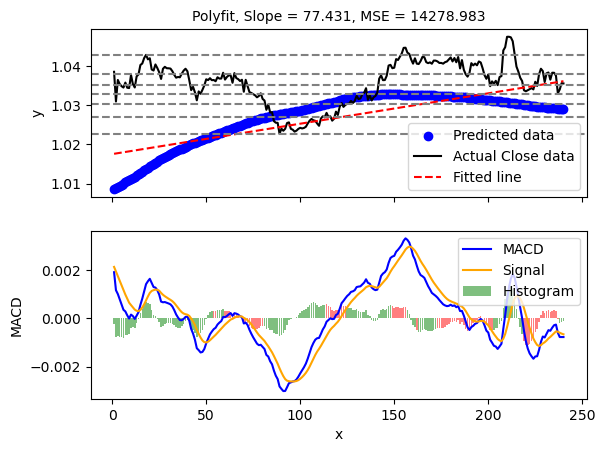

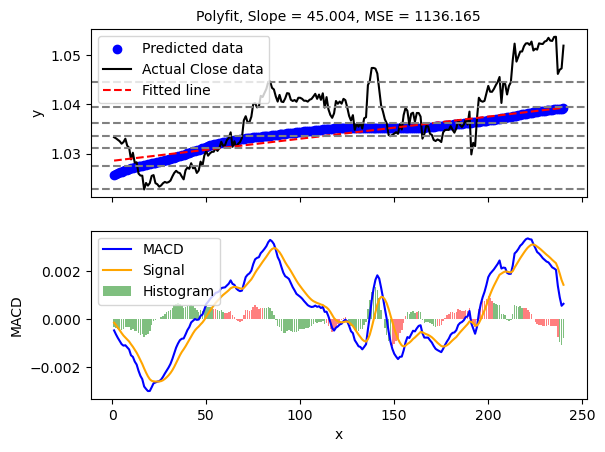

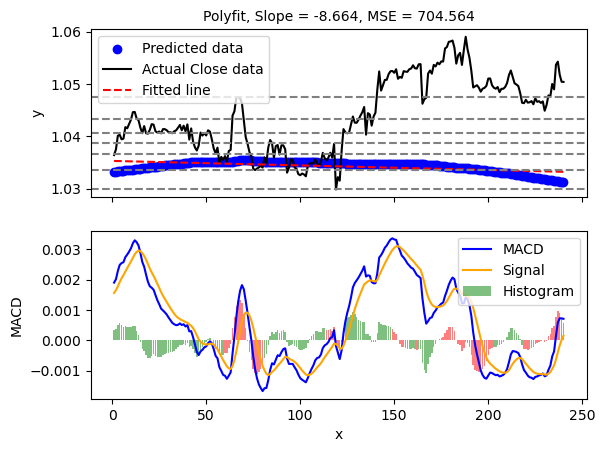

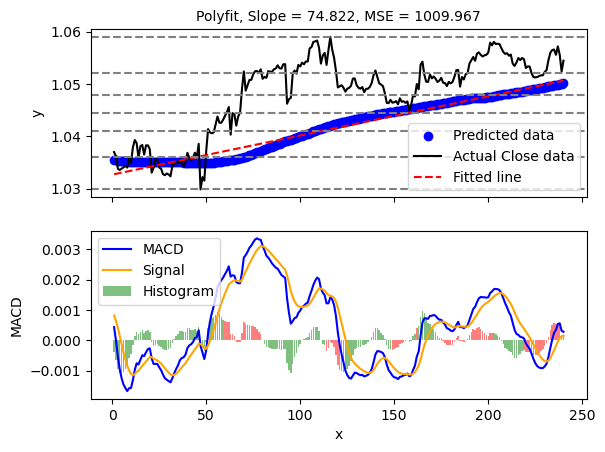

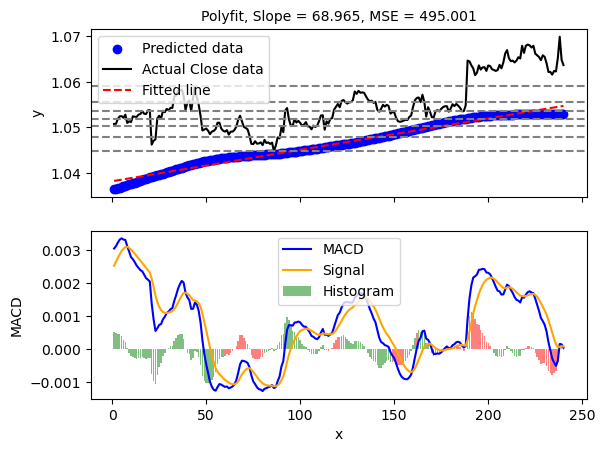

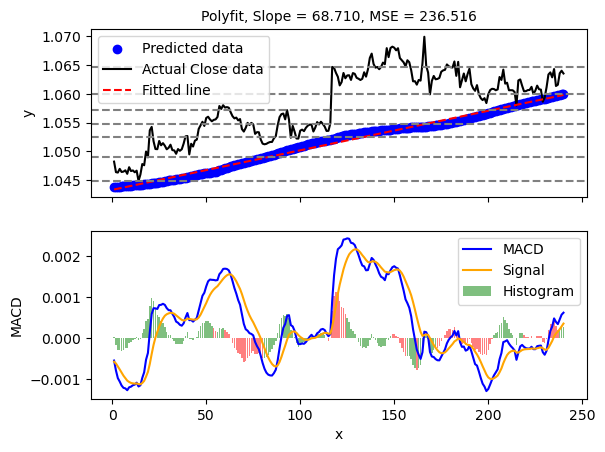

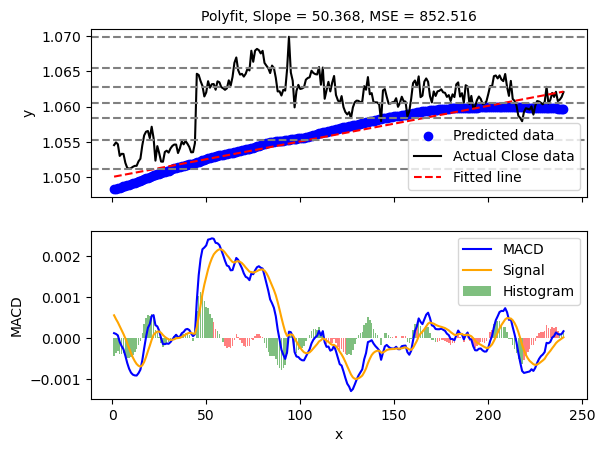

KeyboardInterrupt: 

In [42]:
import sys
import os
import pandas as pd
import numpy as np
import talib
from sklearn.linear_model import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.model_selection import SlidingWindowSplitter
import warnings

splitter = SlidingWindowSplitter(window_length = 67_200, 
                                 fh = np.arange(1, 120 + 1), 
                                 step_length = 24 * 3)
y = df[['SMA']]
for j, (train_idx, test_idx) in enumerate(splitter.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    regressor = LinearRegression()
    forecaster = make_reduction(regressor, window_length = 570, strategy = "recursive")
    forecaster.fit(y_train)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    y_pred = forecaster.predict(fh)
    
    # get last 120 indices from train_idx
    sub_train_idx = train_idx[-120:]
    # combine last 120 indices from train_idx with test_idx
    sub_train_test_idx = np.concatenate([sub_train_idx, test_idx])
    y_test_close = df[['Close']].iloc[sub_train_test_idx]
    # find the highest and lowest prices in the data
    high = df[['Close']].iloc[sub_train_idx]['Close'].max()
    low = df[['Close']].iloc[sub_train_idx]['Close'].min()

    # calculate the Fibonacci retracement levels
    fib_levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    fib_prices = [high - level * (high - low) for level in fib_levels]
    
    
    # y_test_sma = df[['SMA']].iloc[sub_train_test_idx]
    y_pred_prev = df[['SMA']].iloc[sub_train_idx]
    y_pred_combined = pd.concat([y_pred_prev, y_pred])
    y_pred_combined_flatten = y_pred_combined.values.flatten()
    x = np.arange(1, len(y_pred_combined_flatten) + 1)
    
    slope, intercept = np.polyfit(x, y_pred_combined_flatten, 1)
    y_fit = np.polyval([slope, intercept], x)
    mse = np.mean((y_pred_combined_flatten - y_fit) ** 2)
    mse = mse * 10e8
    slope = slope * 10e5
    
    # Create a figure and two subplots using plt.subplots() with sharex=True and assign them to fig, (ax1, ax2)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # Plot y_pred_combined_flatten as blue circles using ax1.scatter()
    ax1.scatter(x, y_pred_combined_flatten, color="blue", label="Predicted data")
    # Plot y_test_close.values.flatten() as black solid line using ax1.plot()
    ax1.plot(x, y_test_close.values.flatten(), color="black", label="Actual Close data")
    # Plot y_fit as red dashed line using ax1.plot()
    ax1.plot(x, y_fit, color="red", linestyle="--", label="Fitted line")
    # Set the title, ylabel and legend using ax1.set_title(), ax1.set_ylabel() and ax1.legend()
    ax1.set_title(f"Polyfit, Slope = {slope:.3f}, MSE = {mse:.3f}", fontsize=10)
    ax1.set_ylabel("y")
    ax1.legend()
    
    # Plot the Fibonacci retracement levels as horizontal lines using plt.hlines() for each price in fib_prices
    for price in fib_prices:
        ax1.axhline(price, 
                    linestyle='--', 
                    color='grey', 
                    label=f'Fibonacci {fib_levels[fib_prices.index(price)] * 100}%')
    
    # Plot macd as a black solid line using ax2.plot()
    macd = df['MACD'].iloc[sub_train_test_idx]
    macd_signal = df['MACD_Signal'].iloc[sub_train_test_idx]
    macd_hist = df['MACD_Hist'].iloc[sub_train_test_idx]
    
    ax2.plot(x, macd, color="blue", label="MACD")
    ax2.plot(x, macd_signal, color="orange", label="Signal")
    ax2.bar(x, macd_hist, color=["red" if x < 0 else "green" for x in hist], label="Histogram")
    
    # Set the xlabel, ylabel and legend using ax2.set_xlabel(), ax2.set_ylabel() and ax2.legend()
    ax2.set_xlabel("x")
    ax2.set_ylabel("MACD")
    ax2.legend()
    
    # Show the figure using plt.show()
    plt.show()
    
    # plot
    # if mse < 200 and abs(slope) > 30:
    # if abs(slope) > 50:
    # fig, ax = plt.subplots()
    # ax.scatter(x, y_pred_combined_flatten, color="blue", label="Predicted data")
    # # ax.scatter(x, y_test.values.flatten(), color="green", label="Actual SMA data")
    # ax.plot(x, y_test_close.values.flatten(), color="black", label="Actual Close data")
    # ax.plot(x, y_fit, color="red", linestyle="--", label="Fitted line")
    # ax.set_title(f"Polyfit, Slope = {slope:.3f}, MSE = {mse:.3f}", fontsize=10)
    # ax.set_xlabel("x")
    # ax.set_ylabel("y")
    # ax.legend()
    # # Plot the Fibonacci retracement levels as horizontal lines using plt.hlines
    # for price in fib_prices:
    #     plt.axhline(price, linestyle='--', color='grey', label=f'Fibonacci {fib_levels[fib_prices.index(price)] * 100}%')    
    # plt.show()


    

In [ ]:
# import libraries
import talib
import matplotlib.pyplot as plt

# assume you have the price data in a pandas dataframe called df
# calculate the macd, macdsignal and macdhist values
macd, macdsignal, macdhist = talib.MACD(df['Close'])

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# plot the price data on the first subplot
ax1.plot(df['Close'], label='Price')
ax1.set_title('Price and MACD')
ax1.legend()

# plot the macd, macdsignal and macdhist values on the second subplot
ax2.plot(macd, label='MACD')
ax2.plot(macdsignal, label='MACD Signal')
# ax2.bar(df.index, macdhist, label='MACD Histogram')
ax2.set_xlabel('Date')
ax2.legend()

# show the figure
plt.show()

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### XGBoost with multiple inputs

### Tuning the hyperparameters of our forecaster

In [ ]:
from sktime.forecasting.model_selection import SingleWindowSplitter, ForecastingRandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=1)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")
gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions= {
                                        'deseasonalize__model': ['multiplicative', 'additive'],
                                        'detrend__forecaster__degree': [1, 2, 3],
                                        'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
                                        'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
                                        'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__n_estimators': [100, 500, 1000],
                                    }, 
                                     n_iter=1_00, 
                                     random_state=1)

forecaster.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.cv_results_

## Adding components to our forecasting pipeline

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import SingleWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

regressor = XGBRegressor(objective='reg:squarederror', random_state=1)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive")),
    ]
)

param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions=param_grid, 
                                     n_iter=1_00, 
                                     random_state=1)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
gscv.cv_results_

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

# declarative forecaster specification - just two lines!
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, window_length=55, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)


In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    # n_changepoints=int(len(y) / 12),
    )
# forecaster.fit(y_train)  

# y_pred = forecaster.predict(fh=[1,2,3])  